<a href="https://colab.research.google.com/github/JoanFM/graph_neural_networks/blob/main/Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks
Graph Neural Networks are a type of networks that allow us to find relations and connections across our data.
A graph consists of a set of objects (also known as nodes or vertices) where some pairs of objects have connections or edges between them.

In this Notebook we will experiment how they work and their insigths.

This Notebook is structured in the following sections:


1.   Notebook configuration
2.   Importing Libraries

    2.1 Function Utils

3.   Letter Dataset

    3.0  Functions to read and set the Letter Dataset

    3.1  Looking at Letter Dataset.

    3.2  Data Loading

    3.3 Defining a Basic GNN Model

    3.4 Training and Evaluating a Basic GNN Model

    3.5 Conclusions

    3.6 Experiments

4.   GREC Dataset

    4.0 Functions to read and set the GREC Dataset

    4.1 Looking at GREC Database

    4.2 Data Loading

    4.3 Defining Models

    4.4 Training and Comparing Graph Convolutions

    4.5 Results and Conclusions

    4.6 Incorporating Edge Features

    4.7 Over-Smoothing
    

# 1. Notebook Configuration

Connection to drive and gpu configuration


In [ ]:
# -- CONNECT WITH DRIVE -- #
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Mon Apr 27 15:13:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# -- Installing necessary libraries -- #
!pip3 install dgl-cu100

     |████████████████████████████████| 16.8MB 214kB/s 


In [ ]:
# -- Download Letter Data -- #
!wget https://iapr-tc15.greyc.fr/IAM/Letter.zip
!unzip -q Letter.zip

--2020-05-02 08:11:00--  https://iapr-tc15.greyc.fr/IAM/Letter.zip
Resolving iapr-tc15.greyc.fr (iapr-tc15.greyc.fr)... 193.55.128.12, 2001:660:7101::12
Connecting to iapr-tc15.greyc.fr (iapr-tc15.greyc.fr)|193.55.128.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3358644 (3.2M) [application/zip]
Saving to: ‘Letter.zip’

Letter.zip          100%[===================>]   3.20M  4.40MB/s    in 0.7s    

2020-05-02 08:11:02 (4.40 MB/s) - ‘Letter.zip’ saved [3358644/3358644]



In [ ]:
# -- Unzip Datasets from IAPR TC15 -- #
!unzip -q "/content/gdrive/My Drive/graph_neural_networks/Data/GREC.zip"
#!unzip -q "/content/gdrive/My Drive/graph_neural_networks/Data/COIL-DEL.zip"
#!unzip -q "/content/gdrive/My Drive/graph_neural_networks/Data/COIL-RAG.zip"

# 2. Importing Libraries
In this notebook we will use mainly three libraries:

*   PyTorch: know as one of the python libraries to construct ML models.
*   Networkz: helpful library to construct complex models
*   DeepGraphLibrary: which is a extension for PyTorch to construct graph neural networks


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
from random import randrange
import numpy as np
import xml.etree.ElementTree as ET
import networkx as nx
import os
import matplotlib.pyplot as plt
from glob import glob

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## 2.1 Function Utils
Here we will define the functions needed across all the experiments. Here we include the Early Stopping mechanism applied later.

In [ ]:
# -- COLLATE FUNCTION -- #
def collate(samples):
    """
    The input `samples` is a list of pairs (graph, label).
    """
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [ ]:
# -- TRAINING UTILS -- #
from dgl.nn.pytorch import GraphConv, GATConv
from dgl.nn.pytorch import TAGConv, SAGEConv
from dgl.nn.pytorch import Sequential

# -- EARLY STOPPING -- #
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# 3. Letter Dataset

## 3.0 Functions to read and set the Letter Dataset
Here some util functions are defined to help us get the data from the Letter Dataset, but also create the Dataset in PyTorch for the Letter Database.

In [ ]:
# -- CXL PARSER FUNCTION -- #
def getFileList(file_path):
  """Parse CXL file and returns the corresponding file list and class
  """
  elements, classes = [], []
  tree = ET.parse(file_path)
  root = tree.getroot()
  
  for child in root:
    for sec_child in child:
      if sec_child.tag == 'print':
        elements += [sec_child.attrib['file']]
        classes += sec_child.attrib['class']
        
  return elements, classes

In [ ]:
# -- XML PARSER FUNCTION -- #
def read_letters(file):
  """Parse GXL file and returns a networkx graph
  """
  tree_gxl = ET.parse(file)
  root_gxl = tree_gxl.getroot()
  node_label = {}
  node_id = []
  
  # Parse nodes
  for i, node in enumerate(root_gxl.iter('node')):
    node_id += [node.get('id')]
    for attr in node.iter('attr'):
      if (attr.get('name') == 'x'):
        x = float(attr.find('float').text)
      elif (attr.get('name') == 'y'):
        y = float(attr.find('float').text)
    node_label[i] = [x, y]

  node_id = np.array(node_id)

  # Create adjacency matrix
  am = np.zeros((len(node_id), len(node_id)))
  for edge in root_gxl.iter('edge'):
    s = np.where(node_id==edge.get('from'))[0][0]
    t = np.where(node_id==edge.get('to'))[0][0]

    # Undirected Graph
    am[s,t] = 1
    am[t,s] = 1

  # Create the networkx graph
  G = nx.from_numpy_matrix(am)
  nx.set_node_attributes(G, node_label, 'position')
  
  return G

In [ ]:
# -- LETTER DATASET -- #
class Letters(Dataset):
  """Letter Dataset
  """
  def __init__(self, root_path, file_list):
    self.root = root_path
    self.file_list = file_list
    
    # List of files and corresponding labels
    self.graphs, self.labels = getFileList(os.path.join(self.root, self.file_list))
    
    # Labels to numeric value
    self.unique_labels = np.unique(self.labels)
    self.num_classes = len(self.unique_labels)
    
    self.labels = [np.where(target == self.unique_labels)[0][0] 
                   for target in self.labels]
    
    
  def __getitem__(self, index):
    # Read the graph and label
    G = read_letters(os.path.join(self.root, self.graphs[index]))
    target = self.labels[index]
    
    # Convert to DGL format
    g = dgl.DGLGraph()
    g.set_n_initializer(dgl.init.zero_initializer)
    g.set_e_initializer(dgl.init.zero_initializer)
    g.from_networkx(G, node_attrs=['position'])
        
    return g, target
  
  def label2class(self, label):
    # Converts the numeric label to the corresponding string
    return self.unique_labels[label]
  
  def __len__(self):
    # Subset length
    return len(self.labels)

## 3.1 Looking at Letter Database
Graphs that represent distorted letter drawings. They consider the 15 capital letters of the Roman alphabet that consist of straight lines only:

*   (A, E, F, H, I, K, L, M, N, T, V, W, X, Y, Z)

Each node is labeled with a two-dimensional attribute giving its position relative to a reference coordinate system. Edges are unlabeled. The graph database consists of a training set, a validation set, and a test set of size 750 each. Also, three levels of distortions are provided (LOW, MED, HIGH).

Once constructed the graph of each letter out of the XML file, we would want to draw it and see its structure. From the XML file we can see that different letters, distortions and id's are available. 

To observe how the distortion affects the graphs we will try different distortions to see the apparent differences between graphs, to extract some early conclusions.



In [ ]:
# -- CONSTANTS -- #
# Select distortion [LOW, MED, HIGH]
DISTORTION = ['LOW','MED','HIGH']
# Select letter [A, E, F, H, I, K, L, M, N, T, V, W, X, Y, Z]
LETTER = ['A','F','M','V','Y']
# Select id [0-149]
ID = [50, 75, 100, 125]

### Distortion

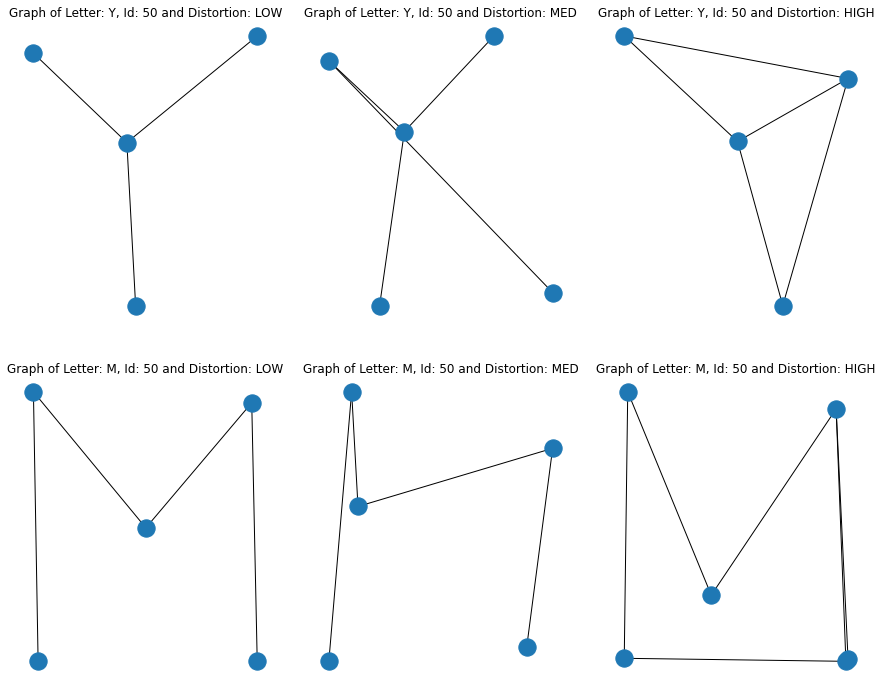

In [ ]:
# -- Influence of DISTORSION for the same letter and identification -- #
letter = LETTER[randrange(len(LETTER))]
ids = ID[randrange(len(ID))]
# -- DISTORTIONS -- #
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(15,12))
axs = [ax0, ax1, ax2, ax3, ax4, ax5]
k = 0
# -- DISTORTIONS -- #
for distortion in DISTORTION:
    G = read_letters(os.path.join('Letter', distortion, letter+'P1_'+ str(ids).zfill(4) +'.gxl'))
    nx.draw(G, pos=dict(G.nodes(data='position')), ax=axs[k])
    axs[k].set_title('Graph of Letter: {0}, Id: {1} and Distortion: {2}'.format(letter, ids, distortion))
    k += 1 
letter = LETTER[randrange(len(LETTER))]
ids = ID[randrange(len(ID))]
for distortion in DISTORTION:
    G = read_letters(os.path.join('Letter', distortion, letter+'P1_'+ str(ids).zfill(4) +'.gxl'))
    nx.draw(G, pos=dict(G.nodes(data='position')), ax=axs[k])
    axs[k].set_title('Graph of Letter: {0}, Id: {1} and Distortion: {2}'.format(letter, ids, distortion))
    k += 1 
plt.show()

Observing the results we can see that distortion measures the amount of noise or distortion applied to the letter graphs, which the form of the letters is affected. So to begin simple we will use the LOW distortion option to create our first GNN.

### Identifier

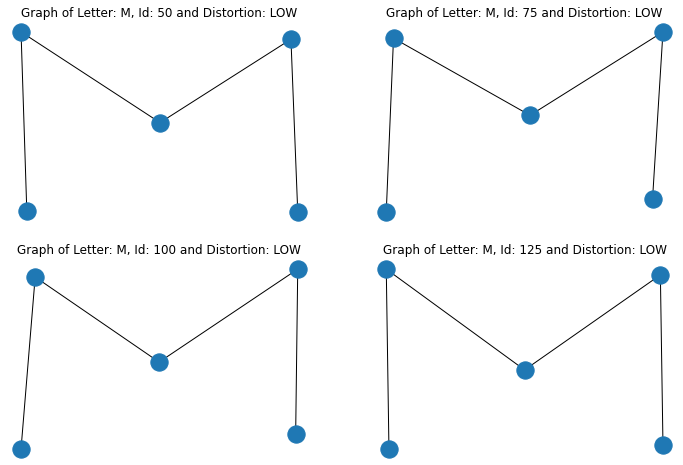

In [ ]:
# -- Changing the Identifier for one distortion and one letter -- #
distortion = DISTORTION[0]
letter = LETTER[randrange(len(LETTER))]
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12,8))
axs = [ax0, ax1, ax2, ax3]
# -- DISTORTIONS -- #
for k, ids in enumerate(ID):
    G = read_letters(os.path.join('Letter', distortion, letter+'P1_'+ str(ids).zfill(4) +'.gxl'))
    nx.draw(G, pos=dict(G.nodes(data='position')), ax=axs[k])
    axs[k].set_title('Graph of Letter: {0}, Id: {1} and Distortion: {2}'.format(letter, ids, distortion))
plt.show()

In the case of the identifiers, they identify different forms of letters.

## 3.2 Data Loading
Now we will create the Datasets and Dataloaders for the Letter Dataset

In [ ]:
bs = 32
distortion = 'LOW'
# -- DEFINE DATASETS -- #
trainset = Letters(os.path.join('Letter', distortion), 'train.cxl')
validset = Letters(os.path.join('Letter', distortion), 'validation.cxl')
testset = Letters(os.path.join('Letter', distortion), 'test.cxl')
# -- CREATE DATALOADERS -- #
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(validset, batch_size=bs, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=bs, collate_fn=collate)
# -- SHOW VALUES -- #
print('Number of training samples: ', len(trainset))
print('Number of validation samples: ', len(validset))
print('Number of test samples: ', len(testset))
print('-'*10)
print('Number of iterations per epoch: ', int(len(trainset)/bs))

Number of training samples:  750
Number of validation samples:  750
Number of test samples:  750
----------
Number of iterations per epoch:  23


## 3.3 Defining a Basic GNN Model

Before we define the GNN first lets represent what a DGL graph structure is, in order to understand more the structure of the graph.


DGLGraph(num_nodes=5, num_edges=8,
         ndata_schemes={'position': Scheme(shape=(2,), dtype=torch.float32)}
         edata_schemes={})




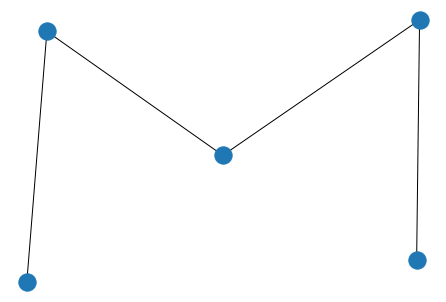

In [ ]:
# -- Get a Graph -- #
distortion = 'LOW'
letter = 'M'
ids = 100
G = read_letters(os.path.join('Letter', distortion, letter+'P1_'+ str(ids).zfill(4) +'.gxl'))
nx.draw(G, pos=dict(G.nodes(data='position')))
# -- Initializing the DGL graph -- #
g = dgl.DGLGraph()
# Transfer NetworkX graph with the corresponding attributes
g.from_networkx(G, node_attrs=['position'])
print(g)
print('\n')

So we can see that our Graph has 5 nodes as we can see on the graph and 8 edges. We only see 4 but because the graph edges are undirectional, the edges are represented as bidireccional so that would be 2x4=8. We also detect that we have two types of data: 

*   ndata
*   edata

We assume that **ndata** are the node features (being the node features) while the **edata** must be the edge features, that for the moment are not used.

We also see that the **ndata** has a Scheme of shape (2,) so we suspect that the input of the GNN should be 2.

Now a simple model will be defined. In the last release, several Graph Convolutions are provided by default as [NN Modules](https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv), so we will be using those.


In [ ]:
class SimpleGNN(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(SimpleGNN, self).__init__()
    self.layers = Sequential(
        GraphConv(in_dim, hidden_dim, activation=F.relu),
        GraphConv(hidden_dim, hidden_dim, activation=F.relu)
    )
    self.classify = nn.Linear(hidden_dim, n_classes)
    
  def forward(self, g):
    h = g.ndata['position']
    if torch.cuda.is_available():
      h = h.cuda()  
    h = self.layers(g,h) 
    g.ndata['h'] = h
    hg = dgl.mean_nodes(g, 'h')
    return self.classify(hg)

## 3.4 Training, Evaluating a Basic GNN Model

Now all is left is to train the Simple GNN, then evaluate it and finally see the results to have some conclusions.


In [ ]:
# -- CONSTANTS -- #
in_dimension = 2
out_dimension = 256
lr = 0.01
epochs = 100
patience = 10
early_flag = False
log_interval = 10

In [ ]:
# -- TRAINING CONFIGURATION -- #
model = SimpleGNN(in_dimension, out_dimension, trainset.num_classes)
if torch.cuda.is_available():
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
if early_flag:
    early_stopping = EarlyStopping(patience=patience, verbose=True)
model.train()
# -- TRAINING -- #
train_losses = []
valid_losses = []
for epoch in range(epochs+1):
    # -- TRAIN SET -- #
    train_loss = 0
    model.train()
    for k, (bg, label) in enumerate(train_loader):
        if torch.cuda.is_available():
            label = label.cuda()
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    # -- VALIDATION SET -- #
    model.eval()
    valid_loss = 0
    for l, (vg, vlabel) in enumerate(valid_loader):
        if torch.cuda.is_available():
            vlabel = vlabel.cuda()
        prediction = model(vg)
        loss = loss_func(prediction, vlabel)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    train_loss /= (k + 1)
    if epoch%log_interval == 0:
        print('Epoch {}, Train Loss {:.4f}, Validation Loss {:.4f}'.format(epoch, train_loss, valid_loss))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if early_flag:
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

# -- SAVE MODEL -- #
if early_flag:
    print('Stoped at epoch: ', epoch)
    model.load_state_dict(torch.load('checkpoint.pt'))
torch.save(model.state_dict(),'/content/gdrive/My Drive/graph_neural_networks/Models/low_basic.pkl')

Epoch 0, Train Loss 2.6294, Validation Loss 2.3672
Epoch 10, Train Loss 0.6441, Validation Loss 0.6886
Epoch 20, Train Loss 0.4026, Validation Loss 0.5803
Epoch 30, Train Loss 0.2832, Validation Loss 0.5960
Epoch 40, Train Loss 0.1993, Validation Loss 0.5070
Epoch 50, Train Loss 0.1209, Validation Loss 0.5091
Epoch 60, Train Loss 0.0861, Validation Loss 0.5244
Epoch 70, Train Loss 0.0889, Validation Loss 0.6188
Epoch 80, Train Loss 0.1284, Validation Loss 0.7009
Epoch 90, Train Loss 0.0187, Validation Loss 0.5750
Epoch 100, Train Loss 0.0266, Validation Loss 0.5958


In [ ]:
# -- ACCURACY FUNCTION -- #
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]

# -- EVALUATION -- #
model.eval()
acc = 0
with torch.no_grad():
  for k, (bg, label) in enumerate(test_loader):
    if torch.cuda.is_available():
        label = label.cuda()
    prediction = model(bg)
    acc += accuracy(prediction, label) * label.shape[0]
acc = acc/len(testset)

print('Test accuracy {:.4f}%'.format(acc))

Test accuracy 93.0667%


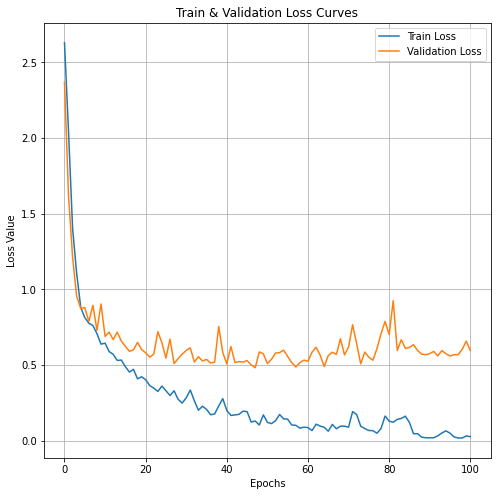

In [ ]:
# -- PLOTTING TRAIN AND VALIDATION LOSS -- #
filename = 'low_basic_losses.png'
plt.figure(1, figsize=(8,8))
x = [item for item in range(epochs+1)]
plt.plot(x, train_losses, color='tab:blue', label='Train Loss')
plt.plot(x, valid_losses, color='tab:orange', label='Validation Loss')
plt.title('Train & Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)

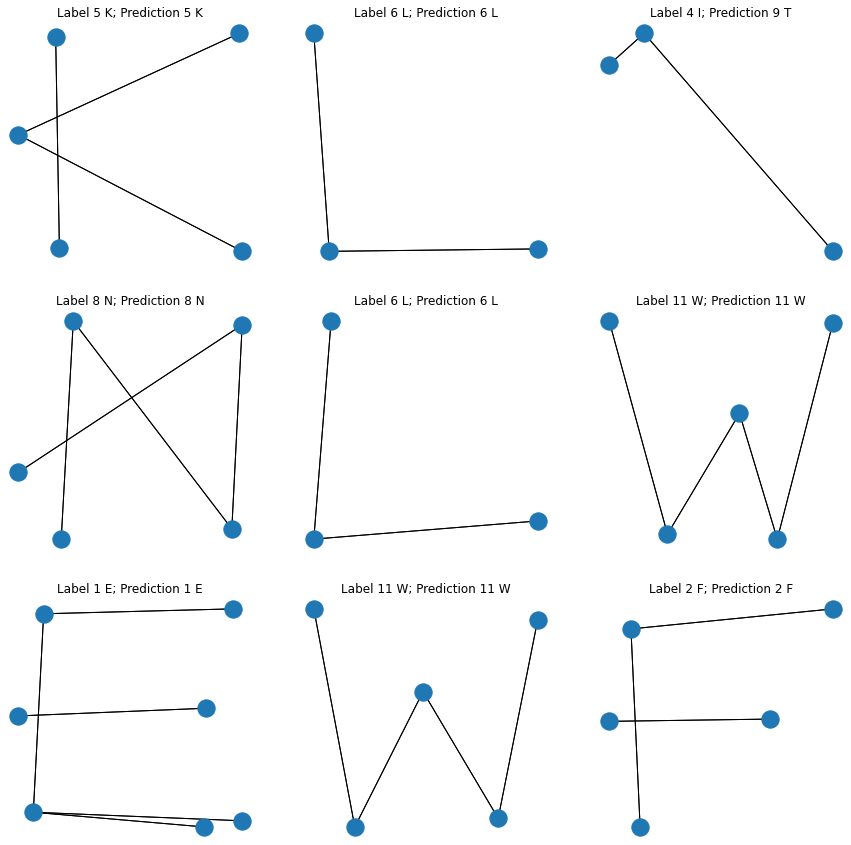

In [ ]:
# -- PLOTTING PREDICTIONS -- #
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(3,3, figsize=(15,15))
axs = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(9):
  index = randrange(len(testset))
  g, label = testset[index]
  pred = model(g)
  _, pred = pred.topk(1)
  G = g.to_networkx(node_attrs=['position'])
  position = {k: v.numpy() for k, v in dict(G.nodes(data='position')).items()}
  nx.draw(G, pos=position, ax=axs[i], arrows=False)
  axs[i].set_title('Label {} {}; Prediction {} {}'.format(label, testset.label2class(label), pred.item(), testset.label2class(pred.item())))
plt.show()

## 3.5 Conclusions
Seeing the results obtained using a LOW distortion with this simple model, some conclusions can be extruded.

* First of all, it is observable that even though the model is very basic, we get around 93.1% of accuracy which is very accurate. 
* If we look at the predictions we can not see any errors other than the one on the first row and third column, where I personally would also have problems to detect and "**I**" vs a "**T**" due to the inclination of the graph.
* Looking at the training and validation losses, it is noticeable that some overfitting is happening, where at some point (30-40 epochs approximately) the validation loss stops decreasing and starts increasing slightly. 

Overall we have seen that with a very simple model we can classify letter graphs, pretty easily. It is true that some overfitting can be seen, but with some changes, we could get a good model.

## 3.6 Experiments
Now we want to experiment and try different configurations, in order to have better conclusions. The first experiment consists on comparing how the same model performs for different distorsions. Due to the fact that some overfitting has been seen, we will implement early stopping. 

In this table we present the results obtained

| Distortion | Accuracy | Train Loss | Valid Loss | Stopped Epoch |
| :---: | :---: | :---: | :---: | :---: |
| LOW | 90.8% | 0.2519 | 0.4531 | 36 |
| MEDIUM | 75.6% | 0.6605 | 0.8154 | 55 |
| HIGH | 52.8% | 1.2717 | 1.4982 | 37 |

As we could intuited, as the distortion increases the simple model has more difficulty to get a good performance and the accuracy drops significally depending on the amount of distortion in the data, as it is more ambiguous.



# 4. GREC Dataset

GREC dataset is a dataset from the IAM Graph Database.
With these Database we will try to develop more complex Graph models and compare them. Later we will add edge features into the data to see if adding edge features helps the best model.

## 4.0 Functions to read and set the GREC Dataset

Here we will define the functions needed to load the GREC dataset and also 

In [ ]:
# -- CXL PARSER FUNCTION -- #
def getGrecList(file_path):
  """Parse CXL file and returns the corresponding file list and class
  """
  elements, classes = [], []
  tree = ET.parse(file_path)
  root = tree.getroot()
  for tab in root.iter('print'):
    elements += [tab.get('file')]
    classes += [tab.get('class')]
        
  return elements, classes

In [ ]:
# -- XML PARSER FUNCTION -- #
import math
def read_grec_graph(file, edge_flag=False):
    """Parse GXL file and returns a networkx graph
    """
    tree_gxl = ET.parse(file)
    root_gxl = tree_gxl.getroot()
    node_label = {}
    node_id = []
    if edge_flag:
        edge_label = {}
  
    # -- Parse Nodes -- #
    for i, node in enumerate(root_gxl.iter('node')):
        node_id += [node.get('id')]
        for attr in node.iter('attr'):
            if (attr.get('name') == 'x'):
                x = float(attr.find('Integer').text)
            elif (attr.get('name') == 'y'):
                y = float(attr.find('Integer').text)
        node_label[i] = [x, y]
    node_id = np.array(node_id)

    # -- Create Adjacency matrix and Parse Edges -- #
    am = np.zeros((len(node_id), len(node_id)))
    for k,edge in enumerate(root_gxl.iter('edge')):
        s = np.where(node_id==edge.get('from'))[0][0]
        t = np.where(node_id==edge.get('to'))[0][0]
        if edge_flag:
            for attr in edge.iter('attr'):
                 if (attr.get('name') == 'angle0'):
                    angle = float(attr.find('String').text)
            edge_label[(s,t)] = [math.cos(angle), math.sin(angle)]
        # Undirected Graph
        am[s,t] = 1
        am[t,s] = 1

    # Create the networkx graph
    G = nx.from_numpy_matrix(am)
    nx.set_node_attributes(G, node_label, 'position')
    if edge_flag:
        nx.set_edge_attributes(G, edge_label, 'angle')
    return G

In [ ]:
# -- GREC DATASET -- #
class GRECDataset(Dataset):
  """Letter Dataset
  """
  def __init__(self, root_path, file_list, edge_flag = False):
    self.root = root_path
    self.file_list = file_list
    self.edge_flag = edge_flag
    
    # List of files and corresponding labels
    self.graphs, self.labels = getGrecList(os.path.join(self.root, self.file_list))
    
    # Labels to numeric value
    self.unique_labels = np.unique(self.labels)
    self.num_classes = len(self.unique_labels)
    
    self.labels = [np.where(target == self.unique_labels)[0][0] 
                   for target in self.labels]
    
  def __getitem__(self, index):
    # Read the graph and label
    G = read_grec_graph(os.path.join(self.root, self.graphs[index]), edge_flag=self.edge_flag)
    target = self.labels[index]

    # Convert to DGL format
    g = dgl.DGLGraph()
    g.set_n_initializer(dgl.init.zero_initializer)
    g.set_e_initializer(dgl.init.zero_initializer)
    if self.edge_flag:
        g.from_networkx(G, node_attrs=['position'], edge_attrs=['angle'])
    else:
        g.from_networkx(G, node_attrs=['position'])
    return g, target
  
  def label2class(self, label):
    # Converts the numeric label to the corresponding string
    return self.unique_labels[label]
  
  def __len__(self):
    # Subset length
    return len(self.labels)

## 4.1 Looking at GREC Database

First of all let's read some graphs from the GREC dataset and see what they look like. For the moment we will only use the node information to do node classification or in other words graphs classification.



In [ ]:
grec_img_list=glob('GREC/data/*.gxl')
print(len(grec_img_list))

1100


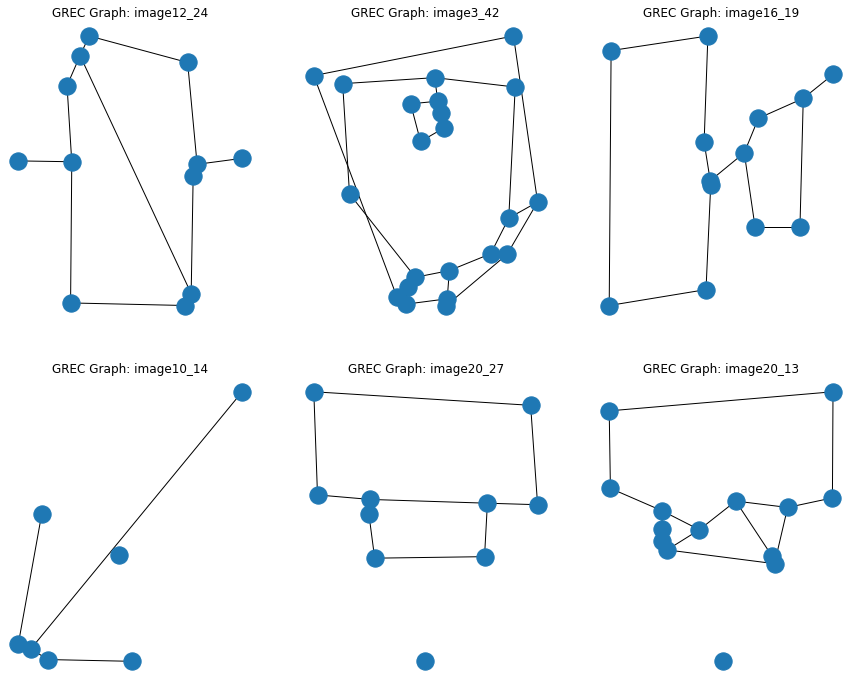

In [ ]:
# -- DISTORTIONS -- #
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(15,12))
axs = [ax0, ax1, ax2, ax3, ax4, ax5]
k = 0
# -- SHOW EXAMPLES -- #
for k in range(len(axs)):
    grec_path = grec_img_list[randrange(len(grec_img_list))]
    G = read_grec_graph(grec_path)
    nx.draw(G, pos=dict(G.nodes(data='position')), ax=axs[k])
    filename = grec_path.split('/')[-1][:-4]
    axs[k].set_title('GREC Graph: {0}'.format(filename))
    k += 1 
plt.show()

As we can see, the graphs in this dataset are much more complex than the ones from the letter dataset. So intuitively we think that the simple model used for the letter dataset will not be sufficient to get a good performance.

Before defining the models, we will present the structure of one graph.


DGLGraph(num_nodes=14, num_edges=32,
         ndata_schemes={'position': Scheme(shape=(2,), dtype=torch.float32)}
         edata_schemes={})




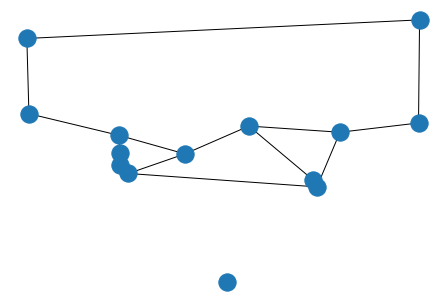

In [ ]:
G = read_grec_graph(grec_img_list[randrange(len(grec_img_list))])
nx.draw(G, pos=dict(G.nodes(data='position')))
# -- Initializing the DGL graph -- #
g = dgl.DGLGraph()
# Transfer NetworkX graph with the corresponding attributes
g.from_networkx(G, node_attrs=['position'])
print(g)
print('\n')

As before the input of the graphs are of shape (2,). 

## 4.2 Data Loading
Now we will create the Datasets and Dataloaders for the Letter Dataset

In [ ]:
bs = 4
# -- DEFINE DATASETS -- #
trainset = GRECDataset(os.path.join('GREC', 'data'), 'train.cxl', edge_flag=True)
validset = GRECDataset(os.path.join('GREC', 'data'), 'valid.cxl',edge_flag=True)
testset = GRECDataset(os.path.join('GREC', 'data'), 'test.cxl', edge_flag=True)
# -- CREATE DATALOADERS -- #
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(validset, batch_size=bs, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=bs, collate_fn=collate)
# -- SHOW VALUES -- #
print('Number of training samples: ', len(trainset))
print('Number of validation samples: ', len(validset))
print('Number of test samples: ', len(testset))
print('-'*10)
print('Number of iterations per epoch: ', int(len(trainset)/bs))

Number of training samples:  286
Number of validation samples:  286
Number of test samples:  528
----------
Number of iterations per epoch:  71


## 4.3 Defining the Models
For the moment we will be only using the node information. Our intention is to compare the use of different graph convolution layers such as:

*  ***GraphConv***: (Normal Convolution)
*  ***GATConv*** or Self Attention Graph Conv: (Convolution with self Attention mechanism)
*  ***TAGConv*** or Topology Adaptive Graph Convolutional: (Convolution that takes into account topology of the graph)
*  ***SAGEConv*** or GraphSAGE: (Which proposes a new batch algorithm to save memory)

Because the graphs of GREC appear to be more complex, we will define the model more complex than the previous one, so instead of 2 layers we will add one more. 

We do not add more because adding many layers could cause over-smoothing, which is caused after many linear aggregations. In other words, using deeper GNN cause over-smoothing, which produces a decrease in performance. So with 3 layers the model is complex enough to have the sufficient capacity without having the oportunity to over-smooth. 

In [ ]:
graphconv_option = ['GraphConv', 'GATConv', 'TAGConv', 'SAGEConv']

class GATView(nn.Module):
    def __init__(self):
        super(GATView, self).__init__()
    
    def forward(self, g, h):
        h = torch.mean(h,1,keepdim=True)
        h = torch.squeeze(h,1)
        return h

class GCNN(nn.Module):
    def __init__(self, in_dim, n_classes, conv_type='GraphConv'):
        super(GCNN, self).__init__()
        if conv_type not in graphconv_option:
            raise ValueError('Option of Graph Convolution not available.')
        if conv_type == 'GraphConv':
            self.layers = Sequential(
                GraphConv(in_dim, 128, activation=F.relu),
                GraphConv(128, 256, activation=F.relu),
                GraphConv(256, 512, activation=F.relu))
        elif conv_type == 'GATConv':
            self.layers = Sequential(
                GATConv(in_dim, 128, 5, activation=F.relu),
                GATView(),
                GATConv(128, 256, 5, activation=F.relu),
                GATView(),
                GATConv(256, 512, 5, activation=F.relu),
                GATView())
        elif conv_type == 'TAGConv':
            self.layers = Sequential(
                TAGConv(in_dim, 128, activation=F.relu),
                TAGConv(128, 256, activation=F.relu),
                TAGConv(256, 512, activation=F.relu))
        elif conv_type == 'SAGEConv':
            self.layers = Sequential(
                SAGEConv(in_dim, 128, 'mean', activation=F.relu),
                SAGEConv(128, 256, 'mean', activation=F.relu),
                SAGEConv(256, 512, 'mean', activation=F.relu))
        self.classify = nn.Linear(512, n_classes)
        self.conv_type = conv_type
    
    def forward(self, g):
        h = g.ndata['position']
        if torch.cuda.is_available():
            h = h.cuda()
        h = self.layers(g,h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

## 4.4 Training and Comparing Graph Convolutions
Once we have defined the model we will train four different models using the different types of convolutions mentioned before. 

It's worth noting that for the GraphConv, TAGConv, SAGEConv we do not need any modifications to the model because they only work with the message and the graph. However the GATConv works using multiheads to assign the attention which produces a different type of tensor.
We have decided to work wiht 5 heads of attention and average them after each convolution.

When comparing we will be using a learning rate of 0.0025 and using early stopping. This way overfitting or over-smoothing will be solved.

In [ ]:
# -- CONSTANTS -- #
in_dimension = 2
conv_type = 'SAGEConv'
lr = 0.0025
epochs = 200
patience = 30
early_flag = True
log_interval = 10

In [ ]:
# -- TRAINING CONFIGURATION -- #
model = GCNN(in_dimension, trainset.num_classes, conv_type=conv_type)
if torch.cuda.is_available():
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
if early_flag:
    early_stopping = EarlyStopping(patience=patience, verbose=False)
model.train()
# -- TRAINING -- #
train_losses = []
valid_losses = []
for epoch in range(epochs+1):
    # -- TRAIN SET -- #
    train_loss = 0
    model.train()
    for k, (bg, label) in enumerate(train_loader):
        if torch.cuda.is_available():
            label = label.cuda()
        
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    # -- VALIDATION SET -- #
    model.eval()
    valid_loss = 0
    for l, (vg, vlabel) in enumerate(valid_loader):
        if torch.cuda.is_available():
            vlabel = vlabel.cuda()
        prediction = model(vg)
        loss = loss_func(prediction, vlabel)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    train_loss /= (k + 1)
    if epoch%log_interval == 0:
        print('Epoch {}, Train Loss {:.4f}, Validation Loss {:.4f}'.format(epoch, train_loss, valid_loss))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if early_flag:
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

# -- SAVE MODEL -- #
if early_flag:
    print('Stoped at epoch: ', epoch)
    model.load_state_dict(torch.load('checkpoint.pt'))
torch.save(model.state_dict(),'/content/gdrive/My Drive/graph_neural_networks/Models/gcnn_sageconv.pkl')

Epoch 0, Train Loss 142.6245, Validation Loss 26.0042
Epoch 10, Train Loss 0.4227, Validation Loss 0.4611
Epoch 20, Train Loss 0.3410, Validation Loss 1.3490
Epoch 30, Train Loss 0.1073, Validation Loss 0.2119
Epoch 40, Train Loss 0.0491, Validation Loss 0.1555
Epoch 50, Train Loss 0.0670, Validation Loss 0.2503
Epoch 60, Train Loss 0.1236, Validation Loss 0.1736
Early stopping
Stoped at epoch:  61


In [ ]:
# -- ACCURACY FUNCTION -- #
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]

# -- EVALUATION -- #
model.eval()
acc = 0
with torch.no_grad():
  for k, (bg, label) in enumerate(test_loader):
    if torch.cuda.is_available():
        label = label.cuda()
    prediction = model(bg)
    acc += accuracy(prediction, label) * label.shape[0]
acc = acc/len(testset)

print('Test accuracy {:.4f}%'.format(acc))

Test accuracy 93.9394%


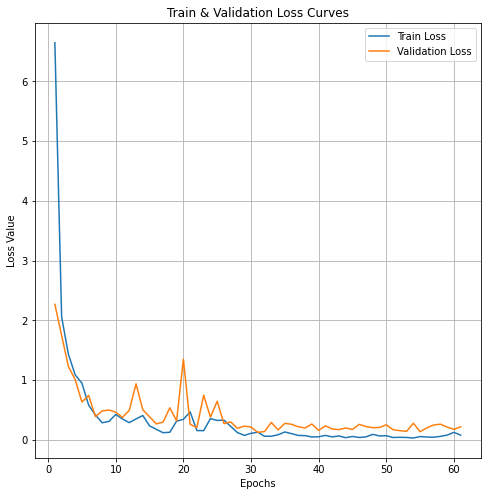

In [ ]:
# -- PLOTTING TRAIN AND VALIDATION LOSS -- #
filename = 'gcnn_sageconv_losses.png'
plt.figure(1, figsize=(8,8))
if early_flag:
    x = [item for item in range(epoch+1)]
else:
    x = [item for item in range(epochs+1)]
plt.plot(x, train_losses, color='tab:blue', label='Train Loss')
plt.plot(x, valid_losses, color='tab:orange', label='Validation Loss')
plt.title('Train & Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)

In [ ]:
# -- FIND TRAIN AND VALID LOSS -- #
val_min = np.argmin(np.array(valid_losses))
print('Min Valid Loss Value: ', valid_losses[val_min])
print('Correspondant Train Loss Value: ', train_losses[val_min])


Min Valid Loss Value:  0.12387679734577735
Correspondant Train Loss Value:  0.1258086987460653


## 4.5 Conclusions and Results:
Once the models have been trained, here we present the results:

|Convolution|Acuracy|Train Loss|Validation Loss|Stop Epoch|
|:---:|:---:|:---:|:---:|:---:|
GraphConv | 87.69% | 0.1498 | 0.5713 | 79
GATConv | 91.67% | 0.1149 | 0.3993 | 58
TAGConv | 95.45% | 0.0544 | 0.2362 | 86
SAGEConv | 93.94% | 0.1258 | 0.1238 | 61

At first sight, it is clear that GraphConv is not the best option when it comes to convolution layers. The performance is not the best, the convergence we see that is slow and the separation between train and validation sets is noticeable.

In the case of GATConv, they convergence fairly quikly and providing more than 90% of accuracy. However their performance is not as good as other methods, even though the improvement of nearly 4% with respect to the GraphConv.

Both TAG and SAGE Convolutions provide similar results (95.5% and 94% respectively), very close to each other, The only difference is the convergence time (where the SAGE is better and can be due to the batch algorithm which is more efficient) and the training and validation losses. It is observable that even though the SAGEConv reaches the lowest value for the validation loss does not reach the highest accuracy. But observing it's training loss we understand why. TAGConv achieves better performance because the training is better than the SAGEConv. However SAGEConv will present morerobustness across noisy graphs than TAGConv. This is observe with the train and validation losses of each one

Because the TAGConv seems to be the best convolution for the model, let's see their predictions.


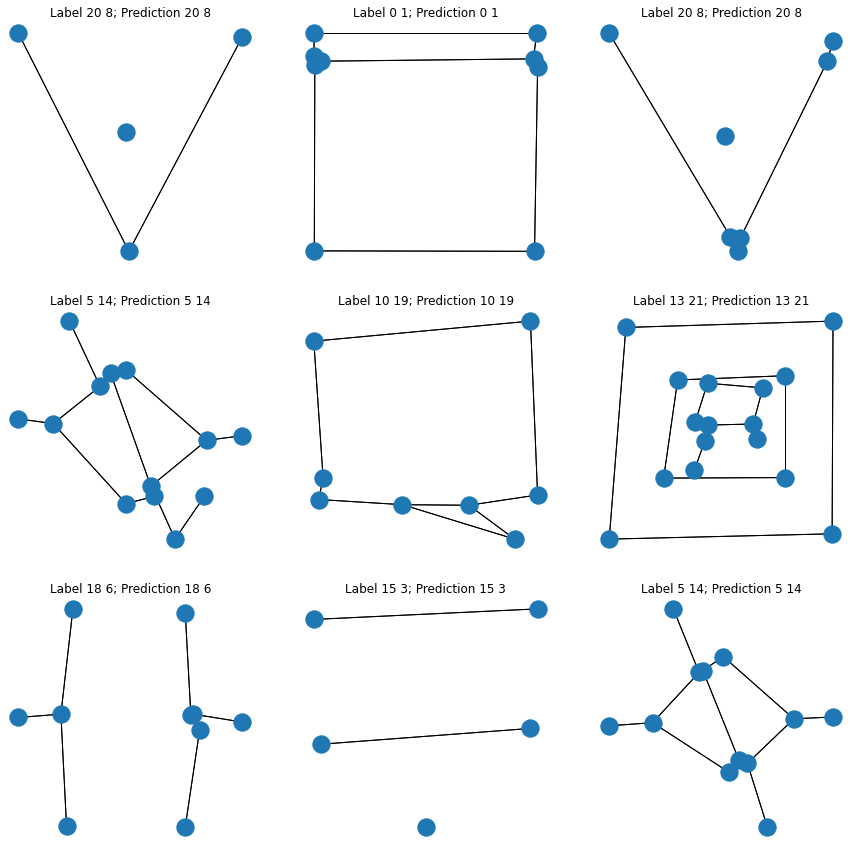

In [ ]:
# -- PLOTTING PREDICTIONS -- #
model = GCNN(in_dimension, trainset.num_classes, conv_type='TAGConv')
model.load_state_dict(torch.load('/content/gdrive/My Drive/graph_neural_networks/Models/gcnn_tagconv.pkl'))
if torch.cuda.is_available():
    model.cuda()
model.eval()
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(3,3, figsize=(15,15))
axs = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(9):
  index = randrange(len(testset))
  g, label = testset[index]
  pred = model(g)
  _, pred = pred.topk(1)
  G = g.to_networkx(node_attrs=['position'])
  position = {k: v.numpy() for k, v in dict(G.nodes(data='position')).items()}
  nx.draw(G, pos=position, ax=axs[i], arrows=False)
  axs[i].set_title('Label {} {}; Prediction {} {}'.format(label, testset.label2class(label), pred.item(), testset.label2class(pred.item())))
plt.show()

With a 95.5% accuracy it is difficult to see any errors

## 4.6 Incorporating Edge Features

To incorporate the edges on the graph we need to add edge attributes to the graph. GREC dataset provides us with the angle of the edges in radiants, which can be used as feature. Instead of taking only the angle, we will compute the cosine and sine of the angle and take those as feature.

DGLGraph(num_nodes=10, num_edges=16,
         ndata_schemes={'position': Scheme(shape=(2,), dtype=torch.float32)}
         edata_schemes={'angle': Scheme(shape=(2,), dtype=torch.float32)})




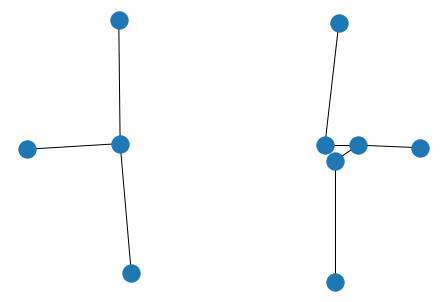

In [ ]:
G = read_grec_graph(grec_img_list[randrange(len(grec_img_list))], edge_flag=True)
nx.draw(G, pos=dict(G.nodes(data='position')))
# -- Initializing the DGL graph -- #
g = dgl.DGLGraph()
# Transfer NetworkX graph with the corresponding attributes
g.from_networkx(G, node_attrs=['position'], edge_attrs=['angle'])
print(g)
print('\n')

As we can see, now the graph contains information about the nodes position and the edge angle, converted in cosine and sine. So as features we have:

*   Node: [x,y]
*   Edge: [cosine(angle),sine(angle)]

Now we have to think how we will incorporate these new features into the message. 

One way is to concatenate the edge and node features into the message. This way with the information of the node position and the angle, the net hopefully will learn to interpret the graphs thanks to the node features and the edge features.

We will compare how the model react depending on the Batch Size.

In [ ]:
def message(edge):
    w = edge.data['w']
    h = edge.src['h']
    m = torch.cat([h, w])
    return {'m': m}

def reduce_node(node):
    accum = torch.sum(node.mailbox['m'],1)
    return {'m': accum}

Now we will define the model, where first we will send the message, and then apply a NN on both the edge features and the node features. Finally we will compute the mean of all those features and concatenate them to form a vector, which then will be used to classify the graph.

In [ ]:
class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = node.data['h']
        h = self.linear(h)
        h = self.activation(h)
        return {'h' : h}

class EdgeApplyModule(nn.Module):
    """Update the edge feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feat, out_feat, activation):
        super(EdgeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feat, out_feat)
        self.activation = activation

    def forward(self, edge):
        w = edge.data['w']
        w = self.linear(w)
        w = self.activation(w)
        return {'w' : w}

class GraphNEConv(nn.Module):
    def __init__(self, in_feat, out_feat, activation):
        super(GraphNEConv, self).__init__()
        self.node_apply = NodeApplyModule(in_feat, out_feat, activation)
        self.edge_apply = EdgeApplyModule(in_feat, out_feat, activation)

    def forward(self, g, node_feat, edge_feat):
        g.ndata['h'] = node_feat
        g.edata['w'] = edge_feat
        g.update_all(message, reduce_node)
        g.apply_edges(func=self.edge_apply)
        g.apply_nodes(func=self.node_apply)
        return g.ndata.pop('h'), g.edata.pop('w')

class GCNNEdges(nn.Module):
  def __init__(self, in_dim, n_classes):
    super(GCNNEdges, self).__init__()
    self.layers = nn.ModuleList([
        GraphNEConv(in_dim, 128, activation=F.relu),
        GraphNEConv(128, 256, activation=F.relu),
        GraphNEConv(256, 512, activation=F.relu)
    ])
    self.classify = nn.Sequential(
        nn.Linear(1024, n_classes)
    )
    
  def forward(self, g):
    h = g.ndata['position']
    w = g.edata['angle']
    if torch.cuda.is_available():
      h = h.cuda() 
      w = w.cuda()
    for conv in self.layers:
        h, w = conv(g, h, w)
    g.ndata['h'] = h
    g.edata['w'] = w
    hg = dgl.mean_nodes(g, 'h')
    wg = dgl.mean_edges(g, 'w')
    hwg = torch.cat([hg,wg],1)
    return self.classify(hwg)

In [ ]:
# -- CONSTANTS -- #
in_dimension = 2
lr = 0.01
epochs = 200
early_flag = True
patience = 100
log_interval = 10

# -- ACCURACY FUNCTION -- #
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]

In [ ]:
# -- TRAINING CONFIGURATION -- #
model = GCNNEdges(in_dimension, trainset.num_classes)
if torch.cuda.is_available():
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
if early_flag:
    early_stopping = EarlyStopping(patience=patience, verbose=False)
model.train()
# -- TRAINING -- #
train_losses = []
valid_losses = []
acc_values = []
for epoch in range(epochs+1):
    # -- TRAIN SET -- #
    train_loss = 0
    model.train()
    for k, (bg, label) in enumerate(train_loader):
        if torch.cuda.is_available():
            label = label.cuda()
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    # -- VALIDATION SET -- #
    model.eval()
    valid_loss = 0
    acc = 0
    for l, (vg, vlabel) in enumerate(valid_loader):
        if torch.cuda.is_available():
            vlabel = vlabel.cuda()
        prediction = model(vg)
        loss = loss_func(prediction, vlabel)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    train_loss /= (k + 1)
    if epoch%log_interval == 0:
        print('Epoch {}, Train Loss {:.4f}, Validation Loss {:.4f}'.format(epoch, train_loss, valid_loss))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    with torch.no_grad():
        for t, (bg, label) in enumerate(test_loader):
            if torch.cuda.is_available():
                label = label.cuda()
            prediction = model(bg)
            acc += accuracy(prediction, label) * label.shape[0]
        acc /= len(testset)
        acc_values.append(acc)
    if early_flag:
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

# -- SAVE MODEL -- #
if early_flag:
    print('Stoped at epoch: ', epoch)
    model.load_state_dict(torch.load('checkpoint.pt'))
torch.save(model.state_dict(),'/content/gdrive/My Drive/graph_neural_networks/Models/gcnn_gcnnedges.pkl')

Epoch 0, Train Loss 12.8043, Validation Loss 2.7401
Epoch 10, Train Loss 1.3484, Validation Loss 1.5948
Epoch 20, Train Loss 1.1948, Validation Loss 1.4235
Epoch 30, Train Loss 1.0609, Validation Loss 1.1366
Epoch 40, Train Loss 1.3644, Validation Loss 1.4609
Epoch 50, Train Loss 1.2644, Validation Loss 1.2375
Epoch 60, Train Loss 0.9784, Validation Loss 1.0710
Epoch 70, Train Loss 0.9461, Validation Loss 1.3655
Epoch 80, Train Loss 1.3510, Validation Loss 1.0957
Epoch 90, Train Loss 0.6595, Validation Loss 1.0570
Epoch 100, Train Loss 0.7217, Validation Loss 1.4777
Epoch 110, Train Loss 0.8870, Validation Loss 0.9883
Epoch 120, Train Loss 0.7186, Validation Loss 0.9978
Early stopping
Stoped at epoch:  128


In [ ]:
# -- EVALUATION -- #
model.eval()
acc = 0
with torch.no_grad():
  for k, (bg, label) in enumerate(test_loader):
    if torch.cuda.is_available():
        label = label.cuda()
    prediction = model(bg)
    acc += accuracy(prediction, label) * label.shape[0]
acc = acc/len(testset)

print('Test accuracy {:.4f}%'.format(acc))
print('Minimum Train Loss: {:.4f}'.format(np.min(train_losses)))
print('Minimum Valid Loss: {:.4f}'.format(np.min(valid_losses)))
print('Maximum Accuracy: {:.4f}'.format(np.max(acc_values)))

Test accuracy 69.8864%
Minimum Train Loss: 0.6595
Minimum Valid Loss: 0.9257
Maximum Accuracy: 76.5152


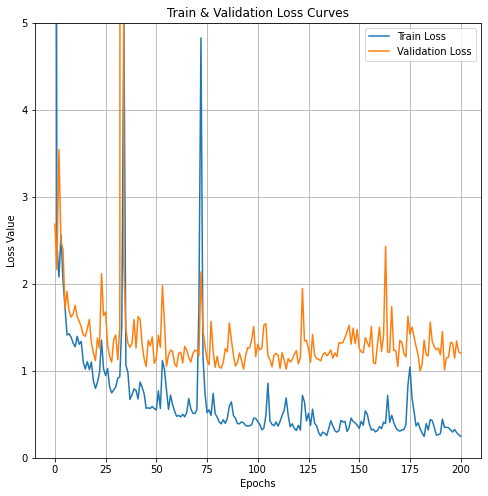

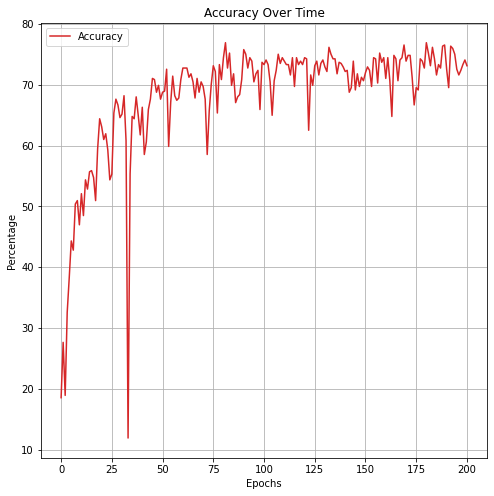

In [ ]:
# -- PLOTTING TRAIN AND VALIDATION LOSS -- #
filename = 'gcnn_edges_loss.png'
plt.figure(1, figsize=(8,8))
x = [item for item in range(epochs+1)]
plt.plot(x, train_losses, color='tab:blue', label='Train Loss')
plt.plot(x, valid_losses, color='tab:orange', label='Validation Loss')
plt.title('Train & Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.axis([-10,210,0,5])
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)
plt.show()
# -- PLOTTING ACCURACY OVER TIME -- #
filename = 'gcnn_edges_acc.png'
plt.figure(1, figsize=(8,8))
x = [item for item in range(epochs+1)]
plt.plot(x, acc_values, color='tab:red', label='Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)
plt.show()

As we can perceive the model, although the accuracy does not surpass the 90% as the previous models, we think that 73% of accuracy is a great result. 

Because we have trained over 200 epochs without early stopping, some over-fitting can be seen, where the validation loss slowly increases over time more than the train loss.

In the case of the Accuracy graph it is observable that around 75 epochs the accuracy is stuck at 73% accuracy which could mean that the capacity of the model is reached.

Here we present the comparison between using different batch sizes.

| Batch Size | Accuracy | Min Train Loss | Min Valid Loss
|:---:|:---:|:---:|:---:|
4 | 69.89 % | 0.6595 | 0.9257
8 | 73.11% | 0.2455 | 1.0000
16 | 61.74% | 0.5402 | 1.3881

As we can see lower batches wrok best when adding the edges.




## 4.7 Over-Smoothing

When training with GNN a common problem is to experience what is known as over-smoothing. This occurs in very deep GNN when the features get too much smooth that the performance starts to drop. 

It is important to understand that the depth of the GNN is related to the number of neighbours that are considered to update the embeddings of a given node with the message passing framework. Therefore, if a too deep GNN is used, information from too many nodes of the graph is acumulated losing characteristic information of the particularities of a node leading to what is understood as Over-Smoothing.

To see it's effect we have implemented a model with 9 GraphConv layers. We will train this model for 200 epochs and see their respective train and validation losses.

Then we will apply skip connections, known to solve the problem and see the results and compare them.

Here are the definitions of both models.

In [ ]:
class GNNWithoutSkip(nn.Module):
  def __init__(self, in_dim, n_classes):
    super(GNNWithoutSkip, self).__init__()
    self.layers = Sequential(
        GraphConv(2, 128, activation=F.relu),
        GraphConv(128, 128, activation=F.relu),
        GraphConv(128, 128, activation=F.relu),
        GraphConv(128, 256, activation=F.relu),
        GraphConv(256, 256, activation=F.relu),
        GraphConv(256, 256, activation=F.relu),
        GraphConv(256, 512, activation=F.relu),
        GraphConv(512, 512, activation=F.relu),
        GraphConv(512, 512, activation=F.relu),
    )
    self.classify = nn.Linear(512, n_classes)
    
  def forward(self, g):
    h = g.ndata['position']
    if torch.cuda.is_available():
      h = h.cuda() 
    h = self.layers(g,h)
    g.ndata['h'] = h
    hg = dgl.mean_nodes(g, 'h')
    return self.classify(hg)

class GNNWithSkip(nn.Module):
    def __init__(self, in_dim, n_classes):
        super(GNNWithSkip, self).__init__()
        self.conv1 = GraphConv(2,128,activation=F.relu)
        self.conv1_block = Sequential(
            GraphConv(128,128,activation=F.relu),
            GraphConv(128,128,activation=F.relu)
        )
        self.conv2 = GraphConv(128,256,activation=F.relu)
        self.conv2_block = Sequential(
            GraphConv(256,256,activation=F.relu),
            GraphConv(256,256,activation=F.relu)
        )
        self.conv3 = GraphConv(256,512,activation=F.relu)
        self.conv3_block = Sequential(
            GraphConv(512,512,activation=F.relu),
            GraphConv(512,512,activation=F.relu)
        )
        self.classify = nn.Linear(512, n_classes)
    
    def forward(self, g):
        h = g.ndata['position']
        if torch.cuda.is_available():
         h = h.cuda() 
        hc1 = self.conv1(g,h)
        hc1b = self.conv1_block(g,hc1)
        h = torch.add(hc1,hc1b)
        hc2 = self.conv2(g,h)
        hc2b = self.conv2_block(g,hc2)
        h = torch.add(hc2,hc2b)
        hc3 = self.conv3(g,h)
        hc3b = self.conv3_block(g,hc3)
        h = torch.add(hc3,hc3b)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [ ]:
# -- CONSTANTS -- #
in_dimension = 2
lr = 0.01
epochs = 200
log_interval = 10

# -- ACCURACY FUNCTION -- #
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]

In [ ]:
# -- TRAINING CONFIGURATION -- #
model = GNNWithSkip(in_dimension, trainset.num_classes)
if torch.cuda.is_available():
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()
# -- TRAINING -- #
train_losses = []
valid_losses = []
acc_values = []
for epoch in range(epochs+1):
    # -- TRAIN SET -- #
    train_loss = 0
    model.train()
    for k, (bg, label) in enumerate(train_loader):
        if torch.cuda.is_available():
            label = label.cuda()   
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    # -- VALIDATION SET -- #
    model.eval()
    valid_loss = 0
    acc = 0
    for l, (vg, vlabel) in enumerate(valid_loader):
        if torch.cuda.is_available():
            vlabel = vlabel.cuda()
        prediction = model(vg)
        loss = loss_func(prediction, vlabel)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    train_loss /= (k + 1)
    if epoch%log_interval == 0:
        print('Epoch {}, Train Loss {:.4f}, Validation Loss {:.4f}'.format(epoch, train_loss, valid_loss))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    with torch.no_grad():
        for t, (bg, label) in enumerate(test_loader):
            if torch.cuda.is_available():
                label = label.cuda()
            prediction = model(bg)
            acc += accuracy(prediction, label) * label.shape[0]
        acc /= len(testset)
        acc_values.append(acc)

# -- SAVE MODEL -- #
torch.save(model.state_dict(),'/content/gdrive/My Drive/graph_neural_networks/Models/gcnn_skip.pkl')

Epoch 0, Train Loss 42.8385, Validation Loss 3.0878
Epoch 10, Train Loss 2.3054, Validation Loss 2.1470
Epoch 20, Train Loss 1.3308, Validation Loss 1.5214
Epoch 30, Train Loss 1.2560, Validation Loss 1.2629
Epoch 40, Train Loss 0.6058, Validation Loss 0.7870
Epoch 50, Train Loss 0.8562, Validation Loss 1.0364
Epoch 60, Train Loss 0.6092, Validation Loss 0.7366
Epoch 70, Train Loss 0.3196, Validation Loss 0.7247
Epoch 80, Train Loss 0.4512, Validation Loss 0.9916
Epoch 90, Train Loss 1.2872, Validation Loss 1.6874
Epoch 100, Train Loss 0.1341, Validation Loss 0.6545
Epoch 110, Train Loss 0.1336, Validation Loss 0.6710
Epoch 120, Train Loss 0.4391, Validation Loss 0.8303
Epoch 130, Train Loss 0.0674, Validation Loss 0.7791
Epoch 140, Train Loss 0.2782, Validation Loss 0.7987
Epoch 150, Train Loss 0.1847, Validation Loss 0.5969
Epoch 160, Train Loss 0.0914, Validation Loss 0.6600
Epoch 170, Train Loss 0.6131, Validation Loss 0.7663
Epoch 180, Train Loss 0.0758, Validation Loss 0.7585
Epo

Here we present the respective train and validation losses of the training without skip connections, where the over-smoothing is pretty clear around epoch 30-40, where the performance starts to decrease. By counterpart the losses start to increase indicating that the model stops learning correctly.

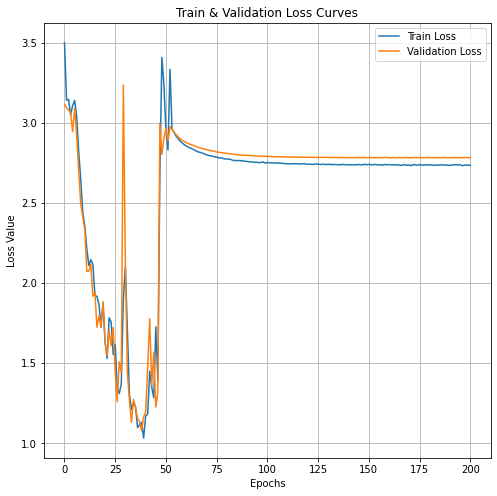

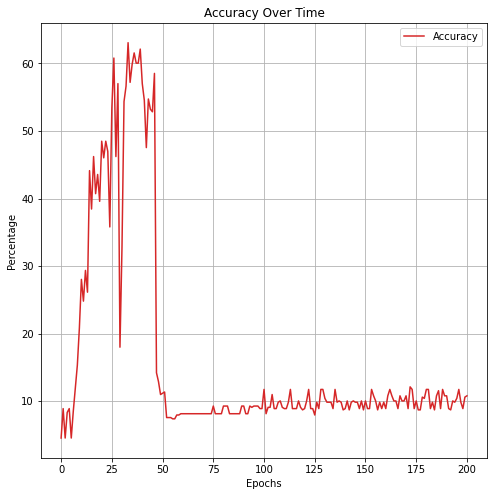

In [ ]:
# -- PLOTTING TRAIN AND VALIDATION LOSS -- #
filename = 'gcnn_wo_skip.png'
plt.figure(1, figsize=(8,8))
x = [item for item in range(epochs+1)]
plt.plot(x, train_losses, color='tab:blue', label='Train Loss')
plt.plot(x, valid_losses, color='tab:orange', label='Validation Loss')
plt.title('Train & Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)
plt.show()
# -- PLOTTING ACCURACY OVER TIME -- #
filename = 'gcnn_wo_skip_acc.png'
plt.figure(1, figsize=(8,8))
x = [item for item in range(epochs+1)]
plt.plot(x, acc_values, color='tab:red', label='Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)
plt.show()

Here the results from the Skip connections GNN are presented. It is very noticeable that no over-smoothing appears. Instead we can observe some kind of overfitting, where at the epoch 47 the validation loss start to increase more than the training loss, indicating overfitting.Is there (at epoch 47), where the accuracy start to increasy very slowly but no significantly drops are visible as before.

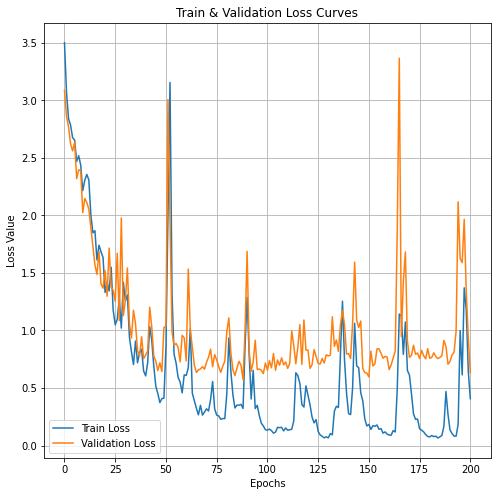

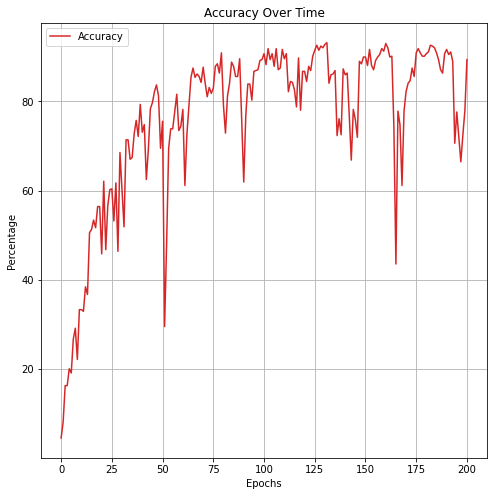

In [ ]:
# -- PLOTTING TRAIN AND VALIDATION LOSS -- #
train_losses[0]=3.5
filename = 'gcnn_w_skip.png'
plt.figure(1, figsize=(8,8))
x = [item for item in range(epochs+1)]
plt.plot(x, train_losses, color='tab:blue', label='Train Loss')
plt.plot(x, valid_losses, color='tab:orange', label='Validation Loss')
plt.title('Train & Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)
plt.show()
# -- PLOTTING ACCURACY OVER TIME -- #
filename = 'gcnn_w_skip_acc.png'
plt.figure(1, figsize=(8,8))
x = [item for item in range(epochs+1)]
plt.plot(x, acc_values, color='tab:red', label='Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/graph_neural_networks/'+filename)
plt.show()

After seeing this effect is important to note that when using deep GNN is recomendable to use skip connections to avoid over-smoothing
